# Download seismic waveforms using Obspy

Reference: [https://docs.obspy.org/packages/obspy.clients.fdsn.html](https://docs.obspy.org/packages/obspy.clients.fdsn.html)

In [2]:
import obspy
import cartopy
from datetime import datetime
import numpy as np
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
client = Client("IRIS")

## Explore Seismic Networks

As an example, we can find all *CI* stations of Southern California Seismic Network within a region of 33.48 N - 33.84 N, 117.19 - 118.94 W from [IRIS](http://ds.iris.edu/gmap/#network=CI&channel=HH*&maxlat=34.84&maxlon=-117.19&minlat=33.48&minlon=-118.94&drawingmode=box&planet=earth)

We then can find station information using Obspy:

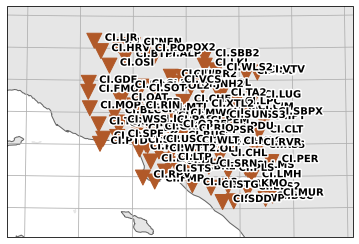

In [3]:
minlatitude=33.48
maxlatitude=34.84
minlongitude=-118.94
maxlongitude=-117.19
stations = client.get_stations(network="CI", station="*", location="*", channel="HH*",
                               minlatitude=minlatitude, maxlatitude=maxlatitude,
                               minlongitude=minlongitude, maxlongitude=maxlongitude)
stations.plot(projection="local", resolution="f");

## Explore Earthquakes

We can also use Obspy to find out the events occured in the past month:

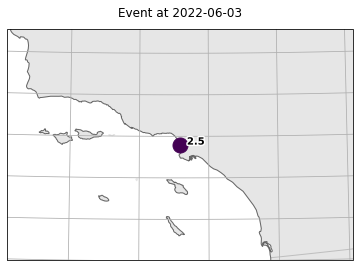

In [4]:
now = UTCDateTime(datetime.now())
# starttime = now - 3600.0*24*30#s
# endtime = now
starttime = UTCDateTime("2022-05-26T00:00:00.000")
endtime = UTCDateTime("2022-06-26T00:00:00.000")
events = client.get_events(starttime=starttime, endtime=endtime,
                           minmagnitude=2.5,
                           minlatitude=minlatitude, maxlatitude=maxlatitude,
                           minlongitude=minlongitude, maxlongitude=maxlongitude)
events.plot(projection="local", resolution="f");

In [6]:
print(events)

1 Event(s) in Catalog:
2022-06-03T12:05:21.050000Z | +33.901, -118.414 | 2.51 Ml


## Download Waveforms

Based on the stations and events information, we now can download the waveforms for analysis.

We can first select one event and one station to look at the waveform:

In [10]:
# We select the station FMP
station = stations.select(station="FMP")
print(station[0][0])

Station FMP (Fort Macarthur Park)
	Station Code: FMP
	Channel Count: 0/175 (Selected/Total)
	2000-08-30T00:00:00.000000Z - 
	Access: open 
	Latitude: 33.71, Longitude: -118.29, Elevation: 89.0 m
	Available Channels:



In [12]:
# The event information:
print(events[0].origins[0])

Origin
	   resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=46955690")
	          time: UTCDateTime(2022, 6, 3, 12, 5, 21, 50000)
	     longitude: -118.413667
	      latitude: 33.9005
	         depth: 11270.0
	 creation_info: CreationInfo(author='ci,us')


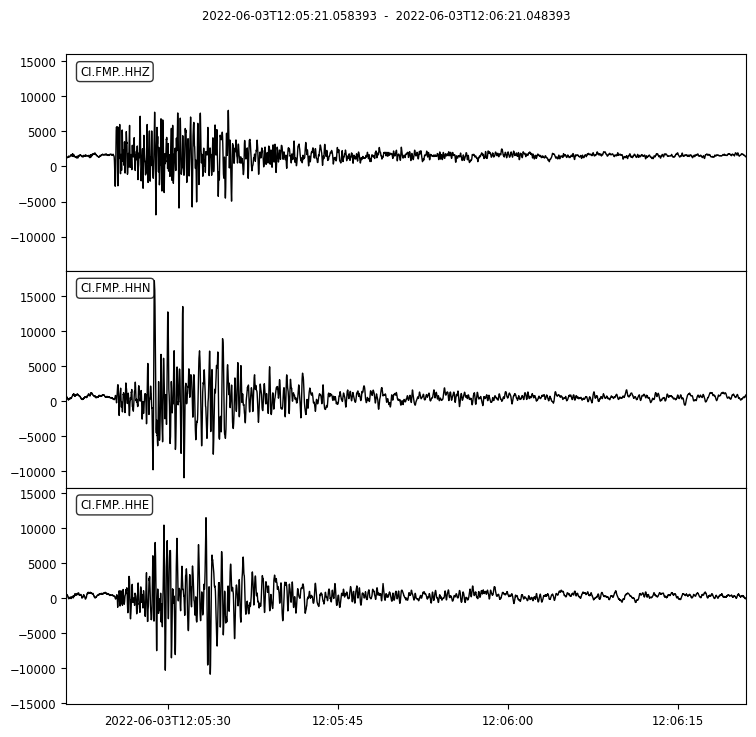

In [13]:
# download and plot the waveforms
waveforms = client.get_waveforms(network=station[0].code,
                                 station=station[0][0].code,
                                 location="*",
                                 channel="HH*", 
                                 starttime=events[0].origins[0].time, 
                                 endtime=events[0].origins[0].time+60)  
waveforms.plot();

Save waveforms for subsequent processing:

## Compare waveforms from seismic network and raspberry shake network 

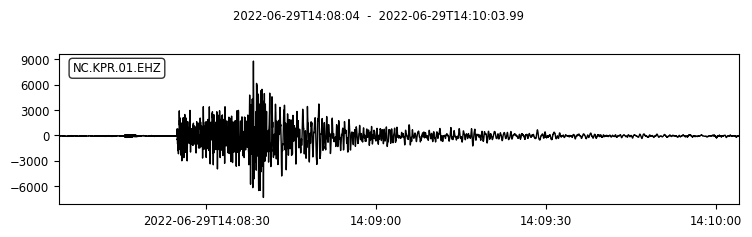

In [ ]:
# download and plot the waveforms from the seismic network
import obspy
from obspy.clients.fdsn import Client
client = Client("NCEDC") ## northern california
# client = Client("SCEDC") ## sourthern california
# client = Client("IRIS") ## global
starttime = UTCDateTime("2022-06-29T14:08:04")
waveforms = client.get_waveforms(network="NC",
                                 station="KPR",
                                 location="*",
                                 channel="*", 
                                 starttime=starttime, 
                                 endtime=starttime+120) #s
waveforms[0].plot();

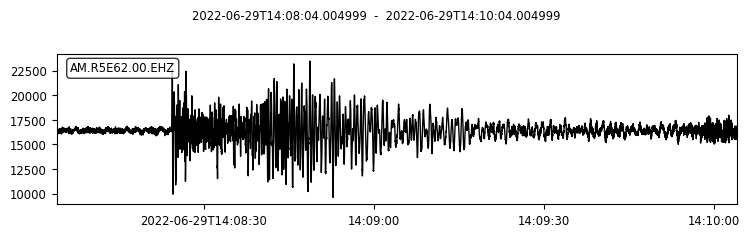

In [ ]:
# download and plot the waveforms from the raspberry shake network
client = Client("RASPISHAKE")
waveforms = client.get_waveforms(network="AM",
                                 station="R5E62", ## change this!
                                 location="*",
                                 channel="*", 
                                 starttime=UTCDateTime("2022-06-29T14:08:04"), 
                                 endtime=UTCDateTime("2022-06-29T14:08:04")+120)  
waveforms[0].plot();

In [7]:
waveforms.write("waveforms.mseed")

## Download waveforms of multiple stations

In [41]:
from obspy.clients.fdsn import RoutingClient
client = RoutingClient("iris-federator")

In [ ]:
stations = client.get_stations(network="CI",
                               channel="HHZ", 
                               starttime=events[0].origins[0].time, 
                               endtime=events[0].origins[0].time+60,
                               latitude=events[0].origins[0].latitude,
                               longitude=events[0].origins[0].longitude,
                               maxradius=0.5, level="channel", )  
# stations.plot(projection="local", resolution="f");

In [ ]:
waveforms = client.get_waveforms(network="CI",
                                 channel="HHZ", 
                                 starttime=events[0].origins[0].time, 
                                 endtime=events[0].origins[0].time+60,
                                 latitude=events[0].origins[0].latitude,
                                 longitude=events[0].origins[0].longitude,
                                 maxradius=0.5, level="channel", )  
# waveforms.plot();

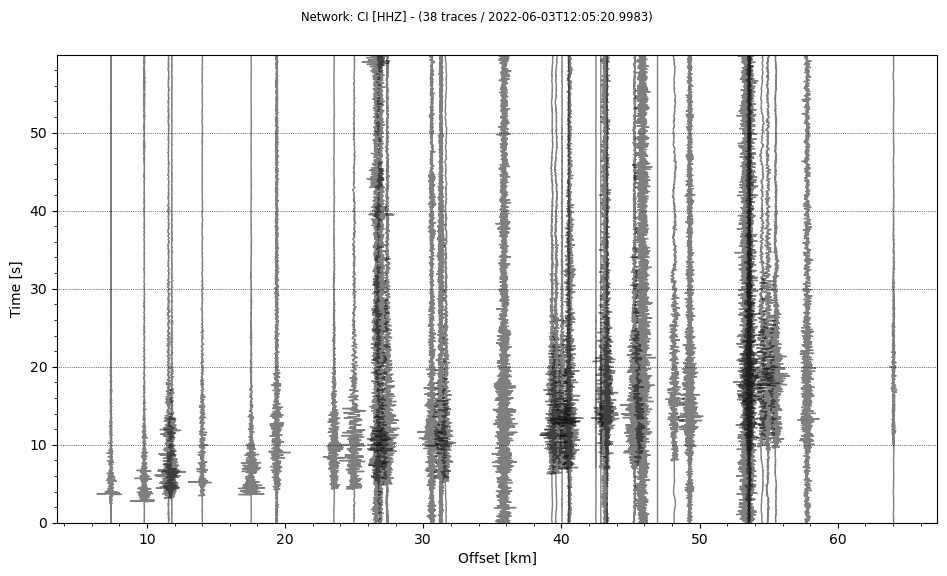

In [57]:
degree2meter = 111.32 * 1e3 #m
for waveform in waveforms:
    station = stations.select(station=waveform.stats.station)[0][0]
    waveform.stats.distance = np.sqrt((station.longitude-events[0].origins[0].longitude)**2 + (station.latitude-events[0].origins[0].latitude)**2) * degree2meter
waveforms.plot(type='section');

## Download Waveforms from the Raspberry Shake network

We can also using the Raspberry Shake network to conduct a similar experiment:

Now we need to use the client of "**RASPISHAKE**" instead of "**IRIS**"

And the network code of Raspberry Shake is [**AM**](https://www.fdsn.org/networks/detail/AM/)

You can find more details from their [manual](https://manual.raspberryshake.org/fdsn.html#fdsnwebservices).

- Explore station of the Raspberry Shake network using [stationview](https://stationview.raspberryshake.org/#/?lat=33.71000&lon=-118.29000&zoom=10.000)

- Or download station information using Obspy

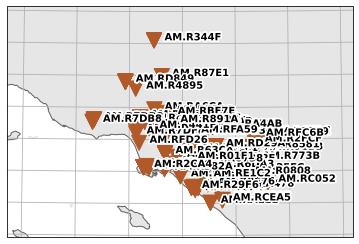

In [8]:
client = Client("RASPISHAKE")
stations = client.get_stations(network="AM", station="*", location="*", channel="*",
                               minlatitude=minlatitude, maxlatitude=maxlatitude,
                               minlongitude=minlongitude, maxlongitude=maxlongitude)
stations.plot(projection="local", resolution="f");

- Downlaod waveform of the same event using the station *R2285* that is close to the event:

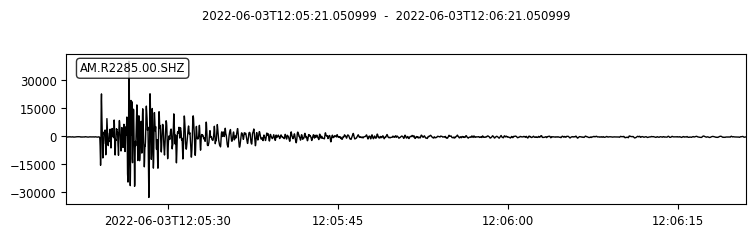

In [21]:
client = Client("RASPISHAKE")
waveforms = client.get_waveforms(network="AM",
                                 station="R2285",
                                 location="*",
                                 channel="*", 
                                 starttime=events[0].origins[0].time, 
                                 endtime=events[0].origins[0].time+60)  
waveforms.plot();

## Compare waveforms from seismic network and raspberry shake network 

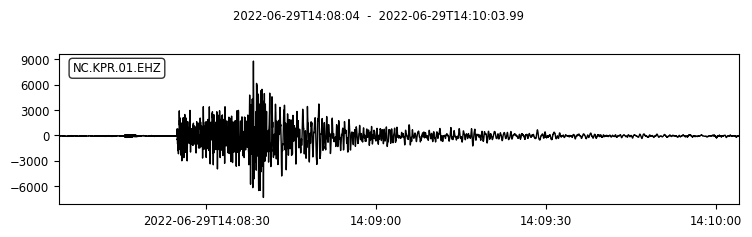

In [ ]:
# download and plot the waveforms from the seismic network
import obspy
from obspy.clients.fdsn import Client
client = Client("NCEDC") ## northern california
# client = Client("SCEDC") ## sourthern california
# client = Client("IRIS") ## global
starttime = UTCDateTime("2022-06-29T14:08:04")
waveforms = client.get_waveforms(network="NC",
                                 station="KPR",
                                 location="*",
                                 channel="*", 
                                 starttime=starttime, 
                                 endtime=starttime+120) #s
waveforms[0].plot();

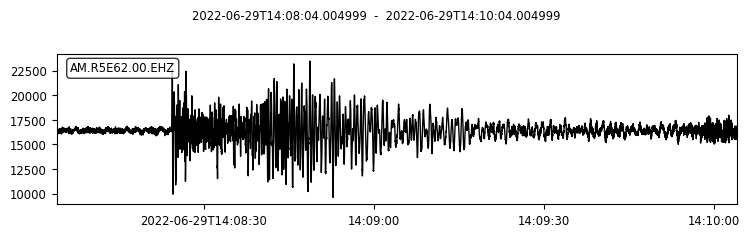

In [ ]:
# download and plot the waveforms from the raspberry shake network
client = Client("RASPISHAKE")
waveforms = client.get_waveforms(network="AM",
                                 station="R5E62", ## change this!
                                 location="*",
                                 channel="*", 
                                 starttime=UTCDateTime("2022-06-29T14:08:04"), 
                                 endtime=UTCDateTime("2022-06-29T14:08:04")+120)  
waveforms[0].plot();